# Assignment 5

Task 1: Use PCA from previous assignment to convert data from 4D to 2D. If you did not manage to implement PCA, you can simply use first 2 dimensions of the database. (4 points if PCA is used, otherwise 1 point)

Task 2a: Implement kNN classification algorithm and apply it to classify iris database. (2 points)

Task 2b: Try different values of k = {1, 2, 3, 4, 5} and print prediction accuracy for validation set. Please select optimal value of k and justify your selection. (3 points)

Task 3: Implement random forest classification and apply it to classify iris database. Use any reasonable parameters you want. (3 points)

Taks 4: Visualize results of kNN and random forests (4 points)

In [1]:
# Load packages as usual
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import random
import matplotlib.cm as cm
import numpy.matlib
from matplotlib.colors import ListedColormap
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier


# Manipulating figure sizes
import matplotlib
matplotlib.rcParams['figure.figsize'] = (15,7)
matplotlib.rc('font', size=15)
matplotlib.rc('axes', titlesize=15)

### Database

We have a database of iris flowers, where each datapoint is defined with 4 features: a) sepal length in cm, b) sepal width in cm, c) petal length in cm, d) petal width in cm. Each datapoint has also a label from the set: Iris Setosa (label = 0), Iris Versicolour (label = 1), Iris Virginica (label = 2).

### Reading data

In [2]:
def __read(fileName, pTrainSamples = 0.6, pValidSamples = 0.2):
    emp_df = pd.read_csv(fileName)
    values = emp_df.values
    values = emp_df.values.astype(np.float)
    
    nTrainSamples = int(values.shape[0] * pTrainSamples)
    nValidSamples = int(values.shape[0] * pValidSamples)
    
    trainingFeatures = values[0:nTrainSamples, 0:-1]
    trainingLabels   = values[0:nTrainSamples, -1]
    validationFeatures = values[nTrainSamples:nTrainSamples + nValidSamples, 0:-1]
    validationLabels   = values[nTrainSamples:nTrainSamples + nValidSamples, -1]
    testingFeatures    = values[nTrainSamples + nValidSamples:, 0:-1]
    testingLabels      = values[nTrainSamples + nValidSamples:, -1]
    return trainingFeatures.astype(np.float), trainingLabels.astype(np.int), \
           validationFeatures.astype(np.float), validationLabels.astype(np.int), \
           testingFeatures.astype(np.float), testingLabels.astype(np.int)


trainingFeatures, trainingLabels, validationFeatures, validationLabels, testingFeatures, testingLabels = __read('../data/iris_new.csv')
print('shape training = ', trainingFeatures.shape)
print('shape validation = ', validationFeatures.shape)
print('shape testing = ', testingFeatures.shape)

shape training =  (88, 4)
shape validation =  (29, 4)
shape testing =  (31, 4)


C:\Users\askel\AppData\Local\Temp/ipykernel_11652/3928457832.py:4: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  values = emp_df.values.astype(np.float)
C:\Users\askel\AppData\Local\Temp/ipykernel_11652/3928457832.py:15: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  return trainingFeatures.astype(np.float), trainingLabels.astype(np.int), 

### Converting data to two dimensions using PCA

The conversion to 2D from 4D input is needed to simplify visualization of the results. Please generate PCA on the training, and then convert training and testing data from 4D to 2D. 

In [3]:
def __PCA(data):
    data_cent = data - np.mean(data) # center data
    Sigma = np.cov(data_cent.T)#(data_cent.T @ data_cent)/ len(data_cent) # covariance matrix
    PCevals, PCevecs = np.linalg.eigh(Sigma) # eigenvalues and eigenvectors in ascending order
    PCevals = np.flipud(PCevals) # vertical flip  
    PCevecs = np.flip(PCevecs, axis=1) # horisontal flip
    return PCevals, PCevecs


def __transformData(features, PCevecs):
    return np.dot(features,  PCevecs[:, 0:2])


PCevals, PCevecs = __PCA(trainingFeatures)

trainingFeatures2D = __transformData(trainingFeatures, PCevecs)
validationFeatures2D = __transformData(validationFeatures, PCevecs)
testingFeatures2D = __transformData(testingFeatures, PCevecs)
print('shape training = ', trainingFeatures2D.shape)
print('shape validation = ', validationFeatures2D.shape)
print('shape testing = ', testingFeatures2D.shape)

shape training =  (88, 2)
shape validation =  (29, 2)
shape testing =  (31, 2)


### Visualizing 2D data

This is visualization of the training data with labels.

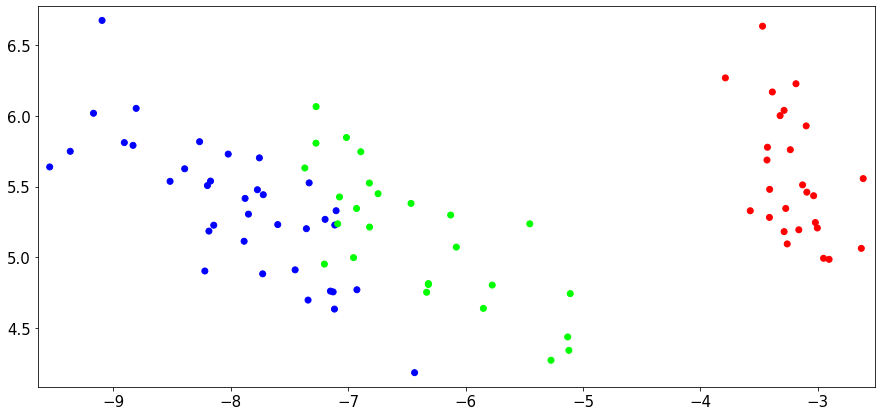

In [4]:
def __visualizeLabels(features, referenceLabels):
    plt.figure()
    cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])
    cmap_bold  = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])
    y = referenceLabels

    plt.scatter(features[:, 0], features[:, 1], c = y, cmap = cmap_bold)
    plt.xlim(features[:, 0].min() - 0.1, features[:, 0].max() + 0.1)
    plt.ylim(features[:, 1].min() - 0.1, features[:, 1].max() + 0.1)
    plt.show()
    t = 0
    
__visualizeLabels(trainingFeatures2D, trainingLabels)

### k-NN implementation

Implement k-NN for prediction of iris labels. Test k-NN for different k-s and find the best one in the space of {1, 2, 3, 4, 5}. Use validation set for testing different k values.

Please note that it is NOT allowed to use KNeighborsClassifier or other existing implementation of k-NN. We expect that can implement it yourself.


In [5]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics


def kNN(trainingFeatures2D, trainingLabels, k, sample):
    '''
    Non-probabilistic classification of a sample using k-Nearest-Neighbors.
    '''
    # compute euclidian distance to every training sample 
    distances = np.sqrt(np.sum((sample - trainingFeatures2D)**2, axis=1))
    
    # select k closest training sample labels
    ind = distances.argsort()[:k] # indices of k nearest training samples
    k_nearest_labels = trainingLabels[ind]
    
    # output most frequent label
    unique_labels, counts = np.unique(k_nearest_labels, return_counts=True)
    
    return unique_labels[np.argmax(counts)]



def __kNNTest(trainingFeatures2D, trainingLabels, n_neighbors, validationFeatures2D, validationLabels):  
    
    # classify validation samples using own implementation of kNN
    classifications = np.array([kNN(trainingFeatures2D, trainingLabels,n_neighbors, sample)
                                for sample in validationFeatures2D])

    # assess classification performance and return 0/1 loss (lower is better)
    accuracy =  1 - np.average([classification == validation
                               for (classification, validation)
                               in zip(classifications, validationLabels)])

    return accuracy

for n in range(1, 6):
    print('accuracy = ', __kNNTest(trainingFeatures2D, trainingLabels, n, validationFeatures2D, validationLabels))

# distribution of training labels
labels, counts = np.unique(trainingLabels, return_counts=True)
print("Distribution of training labels: ", dict(zip(labels,counts)))

accuracy =  0.06896551724137934
accuracy =  0.03448275862068961
accuracy =  0.0
accuracy =  0.0
accuracy =  0.0
Distribution of training labels:  {0: 26, 1: 26, 2: 36}


### Random forests implementation

Implement random forest for prediciton of iris labels. Select any reasonable configuration of parameters for the random forest predictor

Here you are allowed to use existing implementations, please check RandomForestClassifier from sklearn

In [6]:
def __randomForests(trainingFeatures2D, trainingLabels):
    #---put your code here
    predictor = RandomForestClassifier() # default settings
    predictor.fit(trainingFeatures2D, trainingLabels)
    return predictor

predictor = __randomForests(trainingFeatures2D, trainingLabels)

### Visualizing predictor boundaries

Modify function __visualizeLabels to visualize not only labels but also decision boundaries of a predictor. Apply kNN classifier with optimal k on testing features and visualize the obtained results. Visualize the obtained results in comparion with the true testing labels. Apply random forest classifier on testing features and visualize the obtained results.

Here, you are allowed to use KNeighborsClassifier in __kNN.

Hint: check this example https://stackoverflow.com/questions/41138706/recreating-decision-boundary-plot-in-python-with-scikit-learn-and-matplotlib

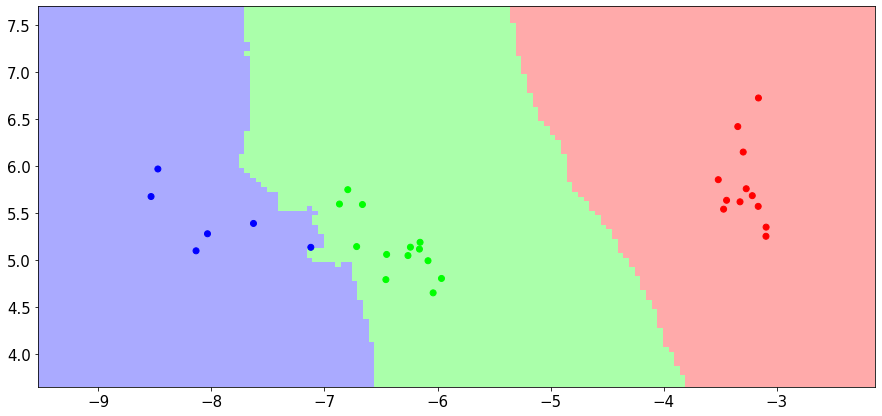

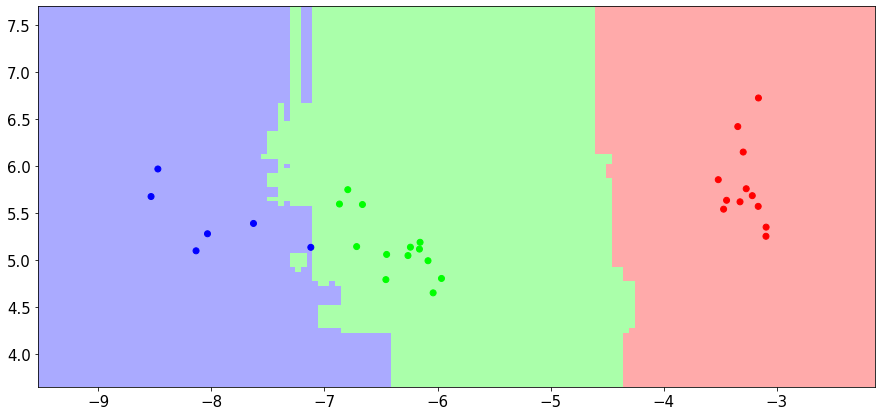

In [7]:
def __visualizePredictions(predictor, features, referenceLabels):
    plt.figure()
    cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])
    cmap_bold  = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])
    h = 0.05
    y = referenceLabels
    #---put your code here
    x_min, x_max = features[:, 0].min() - 1, features[:, 0].max() + 1
    y_min, y_max = features[:, 1].min() - 1, features[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    Z = predictor.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    #--- it is expexted that you get xx and yy as coordinates for visualization, and Z as labels for area visualization
    plt.pcolormesh(xx, yy, Z, cmap = cmap_light)
    # Plot also the training points
    plt.scatter(features[:, 0], features[:, 1], c = y, cmap = cmap_bold)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.show()


def __kNN(trainingFeatures2D, trainingLabels, k):
    predictor = KNeighborsClassifier(n_neighbors=k)
    predictor.fit(trainingFeatures2D, trainingLabels)
    return predictor

k = 5
kNNPredictor = __kNN(trainingFeatures2D, trainingLabels, k)
RFPredictor  = __randomForests(trainingFeatures2D, trainingLabels)
__visualizePredictions(kNNPredictor, testingFeatures2D, testingLabels)
__visualizePredictions(RFPredictor, testingFeatures2D, testingLabels)